In [1]:
import numpy as np
from scipy import stats
#import cupy as cp
import matplotlib.pyplot as plt
import cv2

from lib_MHDPIC1D.pic1d import *
from lib_MHDPIC1D.mhd1d import *
from lib_MHDPIC1D.interface import *

Alfven波の伝搬

PIC初期化

In [2]:
c = 1.0
mu_0 = 1.0
epsilon0 = 1.0 / (mu_0 * c**2)
m_electron = 1.0
r_m = 1 / 25
m_ion = m_electron / r_m
t_r = 1.0
ne0_pic = 20 #ここは手動で調整すること
ni0_pic = ne0_pic
B0_pic = np.sqrt(ne0_pic) / 1.0
Te_pic = 0.5 * m_electron * (0.1*c)**2
Ti_pic = Te_pic / t_r
q_electron = -1 * np.sqrt(epsilon0 * Te_pic / ne0_pic)
q_ion = -1 * q_electron
debye_length = np.sqrt(epsilon0 * Te_pic / ne0_pic / q_electron**2)
omega_pe = np.sqrt(ne0_pic * q_electron**2 / m_electron / epsilon0)
omega_pi = np.sqrt(ni0_pic * q_ion**2 / m_ion / epsilon0)
omega_ce = q_electron * B0_pic / m_electron
omega_ci = q_ion * B0_pic / m_ion
VA_pic = B0_pic / np.sqrt(ni0_pic * m_ion + ni0_pic * m_electron)
v_ion = np.array([0.0, 0.0, 0.0])
v_electron = np.array([0.0, 0.0, 0.0])
v_thermal_electron = np.sqrt(2.0 * Te_pic / m_electron)
v_thermal_ion = np.sqrt(2.0 * Ti_pic / m_ion)
ion_inertial_length = c / omega_pi

dx_pic = debye_length
nx_pic = 100
x_min_pic = 1e-10
x_max_pic = nx_pic * dx_pic - 1e-10
x_coordinate_pic = np.arange(0.0, x_max_pic, dx_pic)
dt_pic = 0.0
d_pic = 0.0

E_pic = np.zeros([3, nx_pic])
B_pic = np.zeros([3, nx_pic])
current_pic = np.zeros([3, nx_pic])
rho_pic = np.zeros(nx_pic)
B_pic[2, :] = B0_pic
beta_pic = (ne0_pic * Te_pic + ni0_pic * Ti_pic) / (B0_pic**2 / 2 / mu_0)

n_ion = int(ni0_pic * nx_pic)
n_electron = int(n_ion * abs(q_ion / q_electron))
x_pic_ion = np.zeros([3, n_ion])
x_pic_electron = np.zeros([3, n_electron])
v_pic_ion = np.zeros([3, n_ion])
v_pic_electron = np.zeros([3, n_electron])

rs_ion = np.random.RandomState(10)
rs_electron = np.random.RandomState(20)
x_start_ion = np.linspace(x_min_pic, x_max_pic, n_ion)
x_start_electron = np.linspace(x_min_pic, x_max_pic, n_electron)

x_pic_ion[0, :] = x_start_ion
x_pic_electron[0, :] = x_start_electron
v_pic_ion[0, :] = np.asarray(stats.norm.rvs(v_ion[0], v_thermal_ion, size=n_ion, random_state=30))
v_pic_ion[1, :] = np.asarray(stats.norm.rvs(v_ion[1], v_thermal_ion, size=n_ion, random_state=40))
v_pic_ion[2, :] = np.asarray(stats.norm.rvs(v_ion[2], v_thermal_ion, size=n_ion, random_state=50))
v_pic_electron[0, :] = np.asarray(stats.norm.rvs(v_electron[0], v_thermal_electron, size=n_electron, random_state=60))
v_pic_electron[1, :] = np.asarray(stats.norm.rvs(v_electron[1], v_thermal_electron, size=n_electron, random_state=70))
v_pic_electron[2, :] = np.asarray(stats.norm.rvs(v_electron[2], v_thermal_electron, size=n_electron, random_state=80))

print(f"total number of particles is {n_ion + n_electron}.")
print(f"Box size is {nx_pic}")

total number of particles is 4000.
Box size is 100


MHD初期化 \
U1は上半分、U2は下半分のつもり

In [3]:
gamma_mhd = 5.0 / 3.0
B0_mhd = B0_pic
rho0_mhd = ne0_pic * m_electron + ni0_pic * m_ion
p0_mhd = ne0_pic * Te_pic + ni0_pic * Ti_pic
VA_mhd = B0_mhd / np.sqrt(rho0_mhd)
Cf_mhd = np.sqrt((B0_mhd**2 + 2.0 * p0_mhd) / rho0_mhd)
dx_mhd = dx_pic

nx_mhd = 100
x_min_mhd = 1e-10
x_max_mhd = nx_mhd * dx_mhd - 1e-10
dt_mhd = 0.0
CFL = 0.2
x_coordinate_mhd = np.arange(x_min_mhd, x_max_mhd, dx_mhd)

startpoint = 20
lambda_mhd = 50.0
kx_mhd = 2.0 * np.pi / lambda_mhd
x_coordinate_mhd_perturbation = np.arange(x_min_mhd, lambda_mhd * dx_mhd, dx_mhd)
perturbation_sin = np.zeros(x_coordinate_mhd.shape)
perturbation_sin[startpoint:startpoint+x_coordinate_mhd_perturbation.shape[0]] = -np.sin(kx_mhd * x_coordinate_mhd_perturbation)
U1 = np.zeros([8, nx_mhd])
rho_init = rho0_mhd * (1.0 + 0.2 * perturbation_sin)
u_init = 0.2 * Cf_mhd * perturbation_sin
v_init = 0.0
w_init = 0.0
Bx_init = 0.0
By_init = 0.0
Bz_init = B0_mhd * (1.0 + 0.2 * perturbation_sin)
p_init = p0_mhd * (1.0 + gamma_mhd * 0.2 * perturbation_sin)
U1[0, :] = rho_init
U1[1, :] = rho_init * u_init
U1[2, :] = rho_init * v_init
U1[3, :] = rho_init * w_init
U1[4, :] = Bx_init
U1[5, :] = By_init
U1[6, :] = Bz_init
U1[7, :] = p_init / (gamma_mhd - 1) + rho_init * (u_init**2 + v_init**2 + w_init**2)/2 + (Bx_init**2 + By_init**2 + Bz_init**2)/2

F1 = np.zeros(U1.shape)
F1_bar = np.zeros(F1.shape)
G1 = np.zeros(U1.shape)
G1_bar = np.zeros(G1.shape)

U2 = U1.copy()
F2 = F1.copy()
F2_bar = F1_bar.copy()
G2 = G1.copy()
G2_bar2 = G1_bar.copy()

print(f"U size is {U1.shape}")

U size is (8, 100)


interface用の変数

In [4]:
index_interface_mhd_start = nx_mhd - 20
index_interface_mhd_end = nx_mhd
index_interface_pic_start = 0
index_interface_pic_end = 20

時間発展

In [5]:
#STEP1:PICとMHDの時間を合わせる
#以下、t1からt2に時間発展させるとする
#ただし、t2 = t1 + dt_mhdとする
B_pic_time_ave = np.zeros(B_pic.shape)
zeroth_moment_ion_time_ave = np.zeros(nx_pic)
zeroth_moment_electron_time_ave = np.zeros(nx_pic)
first_moment_ion_time_ave = np.zeros([3, nx_pic])
first_moment_electron_time_ave = np.zeros([3, nx_pic])
second_moment_ion_time_ave = np.zeros([9, nx_pic])
second_moment_electron_time_ave = np.zeros([9, nx_pic])

total_substeps = 10

steps = 300
time_mhd = 0.0
time_pic = 0.0
for step in range(steps+1):

    # save
    if (step % 5 == 0):
        print(f"{step} step done... : time_mhd = {time_mhd:.5f}, time_pic = {time_pic:.5f}, dt_mhd = {dt_mhd:.5f}, dt_pic = {dt_pic:.5f}")
        np.save(f'./results_MH_alfven/x_ion_{step}.npy', x_pic_ion)
        np.save(f'./results_MH_alfven/x_electron_{step}.npy', x_pic_electron)
        np.save(f'./results_MH_alfven/v_ion_{step}.npy', v_pic_ion)
        np.save(f'./results_MH_alfven/v_electron_{step}.npy', v_pic_electron)
        np.save(f'./results_MH_alfven/E_{step}.npy', E_pic)
        np.save(f'./results_MH_alfven/B_{step}.npy', B_pic)
        np.save(f'./results_MH_alfven/current_{step}.npy', current_pic)
        np.save(f"./results_MH_alfven/U1_{step}.npy", U1)

        zeroth_moment_ion = np.zeros(nx_pic)
        zeroth_moment_electron = np.zeros(nx_pic)
        zeroth_moment_ion = get_zeroth_moment(x_pic_ion, nx_pic, dx_pic, zeroth_moment_ion)
        zeroth_moment_electron = get_zeroth_moment(x_pic_electron, nx_pic, dx_pic, zeroth_moment_electron)
        first_moment_ion = np.zeros([3, nx_pic])
        first_moment_electron = np.zeros([3, nx_pic])
        first_moment_ion = get_first_moment(c, v_pic_ion, x_pic_ion, nx_pic, dx_pic, first_moment_ion)
        first_moment_electron = get_first_moment(c, v_pic_electron, x_pic_electron, nx_pic, dx_pic, first_moment_electron)
        second_moment_ion = np.zeros([9, nx_pic])
        second_moment_electron = np.zeros([9, nx_pic])
        second_moment_ion = get_second_moment(c, v_pic_ion, x_pic_ion, nx_pic, dx_pic, second_moment_ion)
        second_moment_electron = get_second_moment(c, v_pic_electron, x_pic_electron, nx_pic, dx_pic, second_moment_electron)

        np.save(f'./results_MH_alfven/zeroth_moment_ion_{step}.npy', zeroth_moment_ion)
        np.save(f'./results_MH_alfven/zeroth_moment_electron_{step}.npy', zeroth_moment_electron)
        np.save(f'./results_MH_alfven/first_moment_ion_{step}.npy', first_moment_ion)
        np.save(f'./results_MH_alfven/first_moment_electron_{step}.npy', first_moment_electron)
        np.save(f'./results_MH_alfven/second_moment_ion_{step}.npy', second_moment_ion)
        np.save(f'./results_MH_alfven/second_moment_electron_{step}.npy', second_moment_electron)

        np.save(f'./results_MH_alfven/B_time_ave_{step}.npy', B_pic_time_ave)
        np.save(f'./results_MH_alfven/zeroth_moment_ion_time_ave_{step}.npy', zeroth_moment_ion_time_ave)
        np.save(f'./results_MH_alfven/zeroth_moment_electron_time_ave_{step}.npy', zeroth_moment_electron_time_ave)
        np.save(f'./results_MH_alfven/first_moment_ion_time_ave_{step}.npy', first_moment_ion_time_ave)
        np.save(f'./results_MH_alfven/first_moment_electron_time_ave_{step}.npy', first_moment_electron_time_ave)
        np.save(f'./results_MH_alfven/second_moment_ion_time_ave_{step}.npy', second_moment_ion_time_ave)
        np.save(f'./results_MH_alfven/second_moment_electron_time_ave_{step}.npy', second_moment_electron_time_ave)

    
    #STEP1:MHD-Predictor
    U1_past = U1.copy()
    #MHD
    #----------------------------------------------------------- 
    
    if True:

        U1_bar = U1.copy()

        rho_mhd = U1[0, :]
        u_mhd = U1[1, :] / rho_mhd
        v_mhd = U1[2, :] / rho_mhd
        w_mhd = U1[3, :] / rho_mhd
        Bx_mhd = U1[4, :]
        By_mhd = U1[5, :]
        Bz_mhd = U1[6, :]
        e_mhd = U1[7, :]
        p_mhd = (gamma_mhd - 1.0) \
            * (e_mhd - 0.5 * rho_mhd * (u_mhd**2+v_mhd**2+w_mhd**2)
                - 0.5 * (Bx_mhd**2+By_mhd**2+Bz_mhd**2))
        F1 = get_flux_HLLD(rho_mhd, u_mhd, v_mhd, w_mhd, Bx_mhd, By_mhd, Bz_mhd, e_mhd, gamma_mhd, F1, axis=0)

        cs_mhd = np.sqrt(gamma_mhd * p_mhd / rho_mhd)
        ca_mhd = np.sqrt((Bx_mhd**2 + By_mhd**2 + Bz_mhd**2) / rho_mhd)
        dt_mhd = CFL * np.min(1.0 / ((np.abs(u_mhd) + np.sqrt(cs_mhd**2 + ca_mhd**2)) / dx_mhd))
        if np.isnan(time_mhd):
            print(f"{step} steps (t = {time_mhd:.3f}) : Calculation is crashed!")
            break
        
        U1_bar += -dt_mhd/dx_mhd * (F1 - np.roll(F1, 1, axis=1))
        U1_bar = boundary_symmetric_x(U1_bar)
        
        rho_mhd = U1_bar[0, :]
        u_mhd = U1_bar[1, :] / rho_mhd
        v_mhd = U1_bar[2, :] / rho_mhd
        w_mhd = U1_bar[3, :] / rho_mhd
        Bx_mhd = U1_bar[4, :]
        By_mhd = U1_bar[5, :]
        Bz_mhd = U1_bar[6, :]
        e_mhd = U1_bar[7, :]
        p_mhd = (gamma_mhd - 1.0) \
            * (e_mhd - 0.5 * rho_mhd * (u_mhd**2+v_mhd**2+w_mhd**2)
                - 0.5 * (Bx_mhd**2+By_mhd**2+Bz_mhd**2))
        F1_bar = get_flux_HLLD(rho_mhd, u_mhd, v_mhd, w_mhd, Bx_mhd, By_mhd, Bz_mhd, e_mhd, gamma_mhd, F1_bar, axis=0)
        F1 = 0.5 * (F1 + F1_bar)

        U1 += -dt_mhd/dx_mhd * (F1 - np.roll(F1, 1, axis=1))
        U1 = boundary_symmetric_x(U1)
        
        #time_mhd += dt_mhd

    #STEP2:PIC
    B_pic_time_ave = np.zeros(B_pic.shape)
    zeroth_moment_ion_time_ave = np.zeros(zeroth_moment_ion_time_ave.shape)
    zeroth_moment_electron_time_ave = np.zeros(zeroth_moment_electron_time_ave.shape)
    first_moment_ion_time_ave = np.zeros(first_moment_ion_time_ave.shape)
    first_moment_electron_time_ave = np.zeros(first_moment_electron_time_ave.shape)
    second_moment_ion_time_ave = np.zeros(second_moment_ion_time_ave.shape)
    second_moment_electron_time_ave = np.zeros(second_moment_electron_time_ave.shape)

    U1_send = U1_past.copy()
    B_pic = send_MHD_to_PICinterface_B(
        index_interface_mhd_start, index_interface_mhd_end, 
        index_interface_pic_start, index_interface_pic_end, 
        U1_send, B_pic
    )
    E_pic = send_MHD_to_PICinterface_E(
        index_interface_mhd_start, index_interface_mhd_end, 
        index_interface_pic_start, index_interface_pic_end, 
        U1_send, E_pic
    )
    current_pic = send_MHD_to_PICinterface_current(
        index_interface_mhd_start, index_interface_mhd_end, 
        index_interface_pic_start, index_interface_pic_end, 
        U1_send, dx_mhd, current_pic
    )
    v_pic_ion, v_pic_electron, x_pic_ion, x_pic_electron = send_MHD_to_PICinterface_particle(
        index_interface_mhd_start, index_interface_mhd_end, 
        index_interface_pic_start, index_interface_pic_end, 
        U1_send, dx_mhd, gamma_mhd, q_electron, 
        m_electron, m_ion, nx_pic, c, 
        v_pic_ion, v_pic_electron, x_pic_ion, x_pic_electron
    )
    
    dt_pic = dt_mhd / total_substeps
    for substep in range(total_substeps):

        B_pic = time_evolution_B(E_pic, dx_pic, dt_pic/2, B_pic) 
        B_pic = boundary_B(B_pic)
        U1_send = U1_past * (total_substeps - (substep + 0.5)) / total_substeps \
                + U1 * (substep + 0.5) / total_substeps
        B_pic = send_MHD_to_PICinterface_B(
            index_interface_mhd_start, index_interface_mhd_end, 
            index_interface_pic_start, index_interface_pic_end, 
            U1_send, B_pic
        )
        
        v_pic_ion = time_evolution_v(c, E_pic, B_pic, x_pic_ion, q_ion, m_ion, nx_pic, dx_pic, dt_pic, v_pic_ion)
        v_pic_electron = time_evolution_v(c, E_pic, B_pic, x_pic_electron, q_electron, m_electron, nx_pic, dx_pic, dt_pic, v_pic_electron)
        x_pic_ion = time_evolution_x(c, dt_pic/2, v_pic_ion, x_pic_ion)
        x_pic_electron = time_evolution_x(c, dt_pic/2, v_pic_electron, x_pic_electron)
        #とりあえず
        v_pic_ion, x_pic_ion = open_condition_x_left(v_pic_ion, x_pic_ion, x_min_pic)
        v_pic_ion, x_pic_ion = refrective_condition_x_right(v_pic_ion, x_pic_ion, x_max_pic)
        v_pic_electron, x_pic_electron = open_condition_x_left(v_pic_electron, x_pic_electron, x_min_pic)
        v_pic_electron, x_pic_electron = refrective_condition_x_right(v_pic_electron, x_pic_electron, x_max_pic)
        U1_send = U1_past * (total_substeps - (substep + 0.5)) / total_substeps \
                             + U1 * (substep + 0.5) / total_substeps
        v_pic_ion, v_pic_electron, x_pic_ion, x_pic_electron = send_MHD_to_PICinterface_particle(
            index_interface_mhd_start, index_interface_mhd_end, 
            index_interface_pic_start, index_interface_pic_end, 
            U1_send, dx_mhd, gamma_mhd, q_electron, 
            m_electron, m_ion, nx_pic, c, 
            v_pic_ion, v_pic_electron, x_pic_ion, x_pic_electron
        )

        current_pic = np.zeros(current_pic.shape)
        current_pic = get_current_density(c, q_ion, v_pic_ion, x_pic_ion, nx_pic, dx_pic, current_pic)
        current_pic = get_current_density(c, q_electron, v_pic_electron, x_pic_electron, nx_pic, dx_pic, current_pic)
        current_pic[:, 0] = current_pic[:, 1]
        current_pic[:, -1] = current_pic[:, -2]
        U1_send = U1_past * (total_substeps - (substep + 0.5)) / total_substeps \
                             + U1 * (substep + 0.5) / total_substeps
        current_pic = send_MHD_to_PICinterface_current(
            index_interface_mhd_start, index_interface_mhd_end, 
            index_interface_pic_start, index_interface_pic_end, 
            U1_send, dx_mhd, current_pic
        )
        
        B_pic = time_evolution_B(E_pic, dx_pic, dt_pic/2, B_pic)
        B_pic = boundary_B(B_pic)
        U1_send = U1_past * (total_substeps - (substep + 1.0)) / total_substeps \
                             + U1 * (substep + 1.0) / total_substeps
        B_pic = send_MHD_to_PICinterface_B(
            index_interface_mhd_start, index_interface_mhd_end, 
            index_interface_pic_start, index_interface_pic_end, 
            U1_send, B_pic
        )
        
        E_pic = time_evolution_E(B_pic, current_pic, c, epsilon0, dx_pic, dt_pic, E_pic)
        E_pic = boundary_E(E_pic)
        rho_pic = np.zeros(rho_pic.shape)
        rho_pic = get_rho(q_ion, x_pic_ion, nx_pic, dx_pic, rho_pic)
        rho_pic = get_rho(q_electron, x_pic_electron, nx_pic, dx_pic, rho_pic)
        rho_pic[0] = rho_pic[1]
        rho_pic[-1] = rho_pic[-2]
        E_pic = filter_E(rho_pic, dx_pic, dt_pic, d_pic, epsilon0, E_pic)
        U1_send = U1_past * (total_substeps - (substep + 1.0)) / total_substeps \
                             + U1 * (substep + 1.0) / total_substeps
        E_pic = send_MHD_to_PICinterface_E(
            index_interface_mhd_start, index_interface_mhd_end, 
            index_interface_pic_start, index_interface_pic_end, 
            U1_send, E_pic
        )
        
        x_pic_ion = time_evolution_x(c, dt_pic/2, v_pic_ion, x_pic_ion)
        x_pic_electron = time_evolution_x(c, dt_pic/2, v_pic_electron, x_pic_electron)
        #とりあえず
        v_pic_ion, x_pic_ion = open_condition_x_left(v_pic_ion, x_pic_ion, x_min_pic)
        v_pic_ion, x_pic_ion = refrective_condition_x_right(v_pic_ion, x_pic_ion, x_max_pic)
        v_pic_electron, x_pic_electron = open_condition_x_left(v_pic_electron, x_pic_electron, x_min_pic)
        v_pic_electron, x_pic_electron = refrective_condition_x_right(v_pic_electron, x_pic_electron, x_max_pic)
        U1_send = U1_past * (total_substeps - (substep + 1.0)) / total_substeps \
                             + U1 * (substep + 1.0) / total_substeps
        v_pic_ion, v_pic_electron, x_pic_ion, x_pic_electron = send_MHD_to_PICinterface_particle(
            index_interface_mhd_start, index_interface_mhd_end, 
            index_interface_pic_start, index_interface_pic_end, 
            U1_send, dx_mhd, gamma_mhd, q_electron, 
            m_electron, m_ion, nx_pic, c, 
            v_pic_ion, v_pic_electron, x_pic_ion, x_pic_electron
        )

        time_pic += dt_pic

        if True:

            B_pic_time_ave += B_pic

            zeroth_moment_ion_tmp = np.zeros(zeroth_moment_ion_time_ave.shape)
            zeroth_moment_electron_tmp = np.zeros(zeroth_moment_electron_time_ave.shape)
            zeroth_moment_ion_tmp = get_zeroth_moment(x_pic_ion, nx_pic, dx_pic, zeroth_moment_ion_tmp)
            zeroth_moment_electron_tmp = get_zeroth_moment(x_pic_electron, nx_pic, dx_pic, zeroth_moment_electron_tmp)
            zeroth_moment_ion_time_ave += zeroth_moment_ion_tmp
            zeroth_moment_electron_time_ave += zeroth_moment_electron_tmp

            first_moment_ion_tmp = np.zeros(first_moment_ion_time_ave.shape)
            first_moment_electron_tmp = np.zeros(first_moment_electron_time_ave.shape)
            first_moment_ion_tmp = get_first_moment(c, v_pic_ion, x_pic_ion, nx_pic, dx_pic, first_moment_ion_tmp)
            first_moment_electron_tmp = get_first_moment(c, v_pic_electron, x_pic_electron, nx_pic, dx_pic, first_moment_electron_tmp)
            first_moment_ion_time_ave += first_moment_ion_tmp
            first_moment_electron_time_ave += first_moment_electron_tmp

            second_moment_ion_tmp = np.zeros(second_moment_ion_time_ave.shape)
            second_moment_electron_tmp = np.zeros(second_moment_electron_time_ave.shape)
            second_moment_ion_tmp = get_second_moment(c, v_pic_ion, x_pic_ion, nx_pic, dx_pic, second_moment_ion_tmp)
            second_moment_electron_tmp = get_second_moment(c, v_pic_electron, x_pic_electron, nx_pic, dx_pic, second_moment_electron_tmp)
            second_moment_ion_time_ave += second_moment_ion_tmp
            second_moment_electron_time_ave += second_moment_electron_tmp

    B_pic_time_ave /= total_substeps
    zeroth_moment_ion_time_ave /= total_substeps
    zeroth_moment_electron_time_ave /= total_substeps
    first_moment_ion_time_ave /= total_substeps
    first_moment_electron_time_ave /= total_substeps
    second_moment_ion_time_ave /= total_substeps
    second_moment_electron_time_ave /= total_substeps

    #STEP3:MHD-Correcter
    U1_past = send_PIC_to_MHDinterface(
        index_interface_mhd_start, index_interface_mhd_end, 
        index_interface_pic_start, index_interface_pic_end, 
        gamma_mhd, m_electron, m_ion, B_pic_time_ave, 
        zeroth_moment_ion_time_ave, zeroth_moment_electron_time_ave, 
        first_moment_ion_time_ave, first_moment_electron_time_ave, 
        second_moment_ion_time_ave, second_moment_electron_time_ave, 
        U1_past
    )


    U1 = U1_past.copy()
    
    if True:

        U1_bar = U1.copy()

        rho_mhd = U1[0, :]
        u_mhd = U1[1, :] / rho_mhd
        v_mhd = U1[2, :] / rho_mhd
        w_mhd = U1[3, :] / rho_mhd
        Bx_mhd = U1[4, :]
        By_mhd = U1[5, :]
        Bz_mhd = U1[6, :]
        e_mhd = U1[7, :]
        p_mhd = (gamma_mhd - 1.0) \
            * (e_mhd - 0.5 * rho_mhd * (u_mhd**2+v_mhd**2+w_mhd**2)
                - 0.5 * (Bx_mhd**2+By_mhd**2+Bz_mhd**2))
        F1 = get_flux_HLLD(rho_mhd, u_mhd, v_mhd, w_mhd, Bx_mhd, By_mhd, Bz_mhd, e_mhd, gamma_mhd, F1, axis=0)

        #cs_mhd = np.sqrt(gamma_mhd * p_mhd / rho_mhd)
        #ca_mhd = np.sqrt((Bx_mhd**2 + By_mhd**2 + Bz_mhd**2) / rho_mhd)
        #dt_mhd = CFL * np.min(1.0 / ((np.abs(u_mhd) + np.sqrt(cs_mhd**2 + ca_mhd**2)) / dx_mhd))
        
        U1_bar += -dt_mhd/dx_mhd * (F1 - np.roll(F1, 1, axis=1))
        U1_bar = boundary_symmetric_x(U1_bar)
        
        rho_mhd = U1_bar[0, :]
        u_mhd = U1_bar[1, :] / rho_mhd
        v_mhd = U1_bar[2, :] / rho_mhd
        w_mhd = U1_bar[3, :] / rho_mhd
        Bx_mhd = U1_bar[4, :]
        By_mhd = U1_bar[5, :]
        Bz_mhd = U1_bar[6, :]
        e_mhd = U1_bar[7, :]
        p_mhd = (gamma_mhd - 1.0) \
            * (e_mhd - 0.5 * rho_mhd * (u_mhd**2+v_mhd**2+w_mhd**2)
                - 0.5 * (Bx_mhd**2+By_mhd**2+Bz_mhd**2))
        F1_bar = get_flux_HLLD(rho_mhd, u_mhd, v_mhd, w_mhd, Bx_mhd, By_mhd, Bz_mhd, e_mhd, gamma_mhd, F1_bar, axis=0)
        F1 = 0.5 * (F1 + F1_bar)

        U1 += -dt_mhd/dx_mhd * (F1 - np.roll(F1, 1, axis=1))
        U1 = boundary_symmetric_x(U1)
        
        time_mhd += dt_mhd

    

0 step done... : time_mhd = 0.00000, time_pic = 0.00000, dt_mhd = 0.00000, dt_pic = 0.00000
5 step done... : time_mhd = 3.90699, time_pic = 3.90699, dt_mhd = 0.78158, dt_pic = 0.07816
10 step done... : time_mhd = 7.81733, time_pic = 7.81733, dt_mhd = 0.78227, dt_pic = 0.07823
15 step done... : time_mhd = 11.73101, time_pic = 11.73101, dt_mhd = 0.78295, dt_pic = 0.07830
20 step done... : time_mhd = 15.64813, time_pic = 15.64813, dt_mhd = 0.78364, dt_pic = 0.07836
25 step done... : time_mhd = 19.56864, time_pic = 19.56864, dt_mhd = 0.78433, dt_pic = 0.07843
30 step done... : time_mhd = 23.49239, time_pic = 23.49239, dt_mhd = 0.78497, dt_pic = 0.07850
35 step done... : time_mhd = 27.41903, time_pic = 27.41903, dt_mhd = 0.78552, dt_pic = 0.07855
40 step done... : time_mhd = 31.34807, time_pic = 31.34807, dt_mhd = 0.78596, dt_pic = 0.07860
45 step done... : time_mhd = 35.27897, time_pic = 35.27897, dt_mhd = 0.78629, dt_pic = 0.07863
50 step done... : time_mhd = 39.21147, time_pic = 39.21147

KeyboardInterrupt: 

プロット

In [9]:
k = 50

B = np.load(f"results_MH_alfven/B_{k}.npy")
E = np.load(f"results_MH_alfven/E_{k}.npy")
current = np.load(f"results_MH_alfven/current_{k}.npy")
x_pic_ion = np.load(f"results_MH_alfven/x_ion_{k}.npy")
x_pic_electron = np.load(f"results_MH_alfven/x_electron_{k}.npy")
v_pic_ion = np.load(f"results_MH_alfven/v_ion_{k}.npy")
v_pic_electron = np.load(f"results_MH_alfven/v_electron_{k}.npy")
zeroth_moment_ion = np.load(f"results_MH_alfven/zeroth_moment_ion_{k}.npy")
zeroth_moment_electron = np.load(f"results_MH_alfven/zeroth_moment_electron_{k}.npy")
first_moment_ion = np.load(f"results_MH_alfven/first_moment_ion_{k}.npy")
first_moment_electron = np.load(f"results_MH_alfven/first_moment_electron_{k}.npy")
second_moment_ion = np.load(f"results_MH_alfven/second_moment_ion_{k}.npy")
second_moment_electron = np.load(f"results_MH_alfven/second_moment_electron_{k}.npy")

B_time_ave = np.load(f"results_MH_alfven/B_time_ave_{k}.npy")
zeroth_moment_ion_time_ave = np.load(f"results_MH_alfven/zeroth_moment_ion_time_ave_{k}.npy")
zeroth_moment_electron_time_ave = np.load(f"results_MH_alfven/zeroth_moment_electron_time_ave_{k}.npy")
first_moment_ion_time_ave = np.load(f"results_MH_alfven/first_moment_ion_time_ave_{k}.npy")
first_moment_electron_time_ave = np.load(f"results_MH_alfven/first_moment_electron_time_ave_{k}.npy")
second_moment_ion_time_ave = np.load(f"results_MH_alfven/second_moment_ion_time_ave_{k}.npy")
second_moment_electron_time_ave = np.load(f"results_MH_alfven/second_moment_electron_time_ave_{k}.npy")

U = np.load(f"results_MH_alfven/U1_{k}.npy")
rho_mhd = U[0, :]
u_mhd = U[1, :] / rho_mhd
v_mhd = U[2, :] / rho_mhd
w_mhd = U[3, :] / rho_mhd
Bx_mhd = U[4, :]
By_mhd = U[5, :]
Bz_mhd = U[6, :]
e_mhd = U[7, :]
p_mhd = (gamma_mhd - 1.0) \
        * (e_mhd - 0.5 * rho_mhd * (u_mhd**2+v_mhd**2+w_mhd**2)
            - 0.5 * (Bx_mhd**2+By_mhd**2+Bz_mhd**2))
Ex_mhd = -(v_mhd * Bz_mhd - w_mhd * By_mhd)
Ey_mhd = -(w_mhd * Bx_mhd - u_mhd * Bz_mhd)
Ez_mhd = -(u_mhd * By_mhd - v_mhd * Bx_mhd)
current_x_mhd = np.zeros(Bx_mhd.shape)
current_y_mhd = -(np.roll(Bz_mhd, -1, axis=0) - np.roll(Bz_mhd, 1, axis=0)) / (2*dx_mhd)
current_z_mhd = (np.roll(By_mhd, -1, axis=0) - np.roll(By_mhd, 1, axis=0)) / (2*dx_mhd)
current_y_mhd[0] = current_y_mhd[1] 
current_y_mhd[-1] = current_y_mhd[-2] 
current_z_mhd[0] = current_z_mhd[1] 
current_z_mhd[-1] = current_z_mhd[-2] 

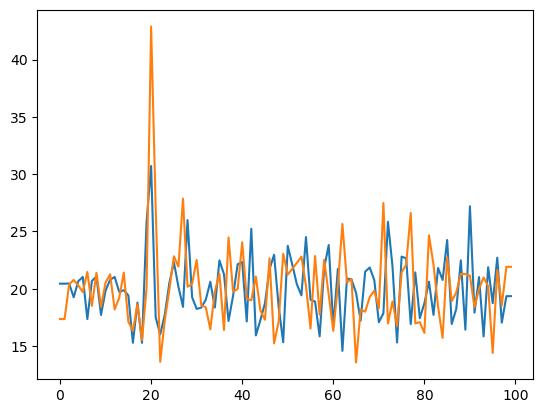

In [10]:
plt.plot(zeroth_moment_ion[:])
plt.plot(zeroth_moment_electron[:])

2002 2016


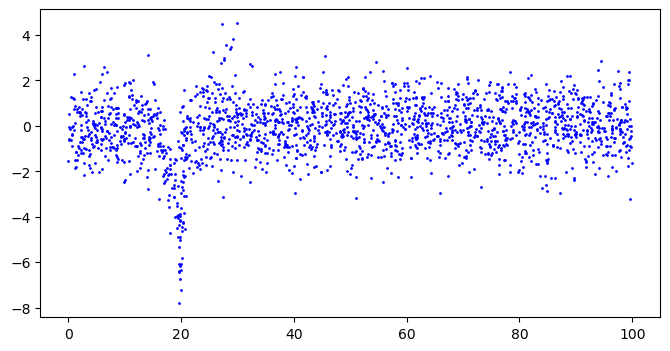

In [11]:
fig = plt.figure(figsize=(8, 4))
ax1 = fig.add_subplot(111)

#plt.scatter(x_pic_ion[0, :], v_pic_ion[0, :] / v_thermal_ion, s=1, color='orange')
plt.scatter(x_pic_electron[0, :], v_pic_electron[1, :] / v_thermal_electron, s=1, color='blue')
#plt.ylim(-10, 10)
#plt.xlim(30, 70)
print(x_pic_ion.shape[1], x_pic_electron.shape[1])

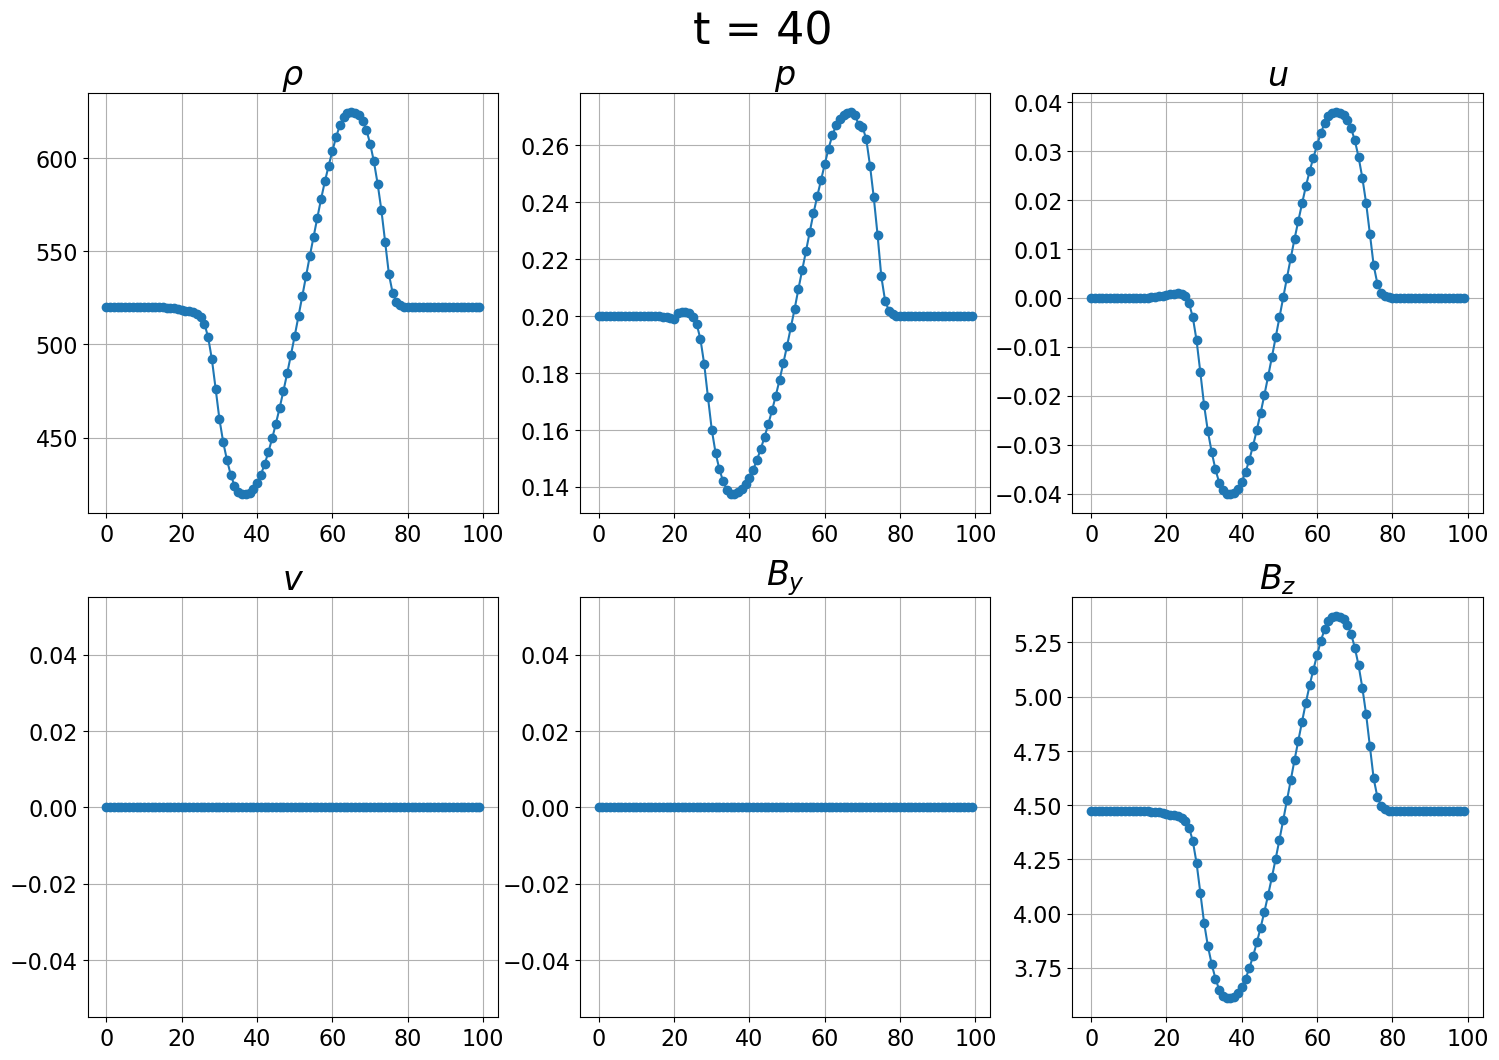

In [ ]:
fig = plt.figure(figsize=(18, 12))
ax1 = fig.add_subplot(231)
ax2 = fig.add_subplot(232)
ax3 = fig.add_subplot(233)
ax4 = fig.add_subplot(234)
ax5 = fig.add_subplot(235)
ax6 = fig.add_subplot(236)

rho = U[0, :]
u = U[1, :] / rho 
v = U[2, :] / rho 
w = U[3, :] / rho 
Bx = U[4, :]
By = U[5, :]
Bz = U[6, :]
e = U[7, :]
p = (gamma_mhd-1) * (e - rho*(u**2+v**2+w**2)/2 - (Bx**2+By**2+Bz**2)/2)

ax1.plot(x_coordinate_mhd, rho, marker='o')
ax2.plot(x_coordinate_mhd, p, marker='o')
ax3.plot(x_coordinate_mhd, u, marker='o')
ax4.plot(x_coordinate_mhd, v, marker='o')
ax5.plot(x_coordinate_mhd, By, marker='o')
ax6.plot(x_coordinate_mhd, Bz, marker='o')

ax1.set_title(r"$\rho$", fontsize=24)
ax2.set_title(r"$p$", fontsize=24)
ax3.set_title(r"$u$", fontsize=24)
ax4.set_title(r"$v$", fontsize=24)
ax5.set_title(r"$B_y$", fontsize=24)
ax6.set_title(r"$B_z$", fontsize=24)
ax1.tick_params(labelsize=16)
ax2.tick_params(labelsize=16)
ax3.tick_params(labelsize=16)
ax4.tick_params(labelsize=16)
ax5.tick_params(labelsize=16)
ax6.tick_params(labelsize=16)
ax1.grid()
ax2.grid()
ax3.grid()
ax4.grid()
ax5.grid()
ax6.grid()

plt.suptitle(f"t = {k}", y=0.95, fontsize=32)

plt.show()

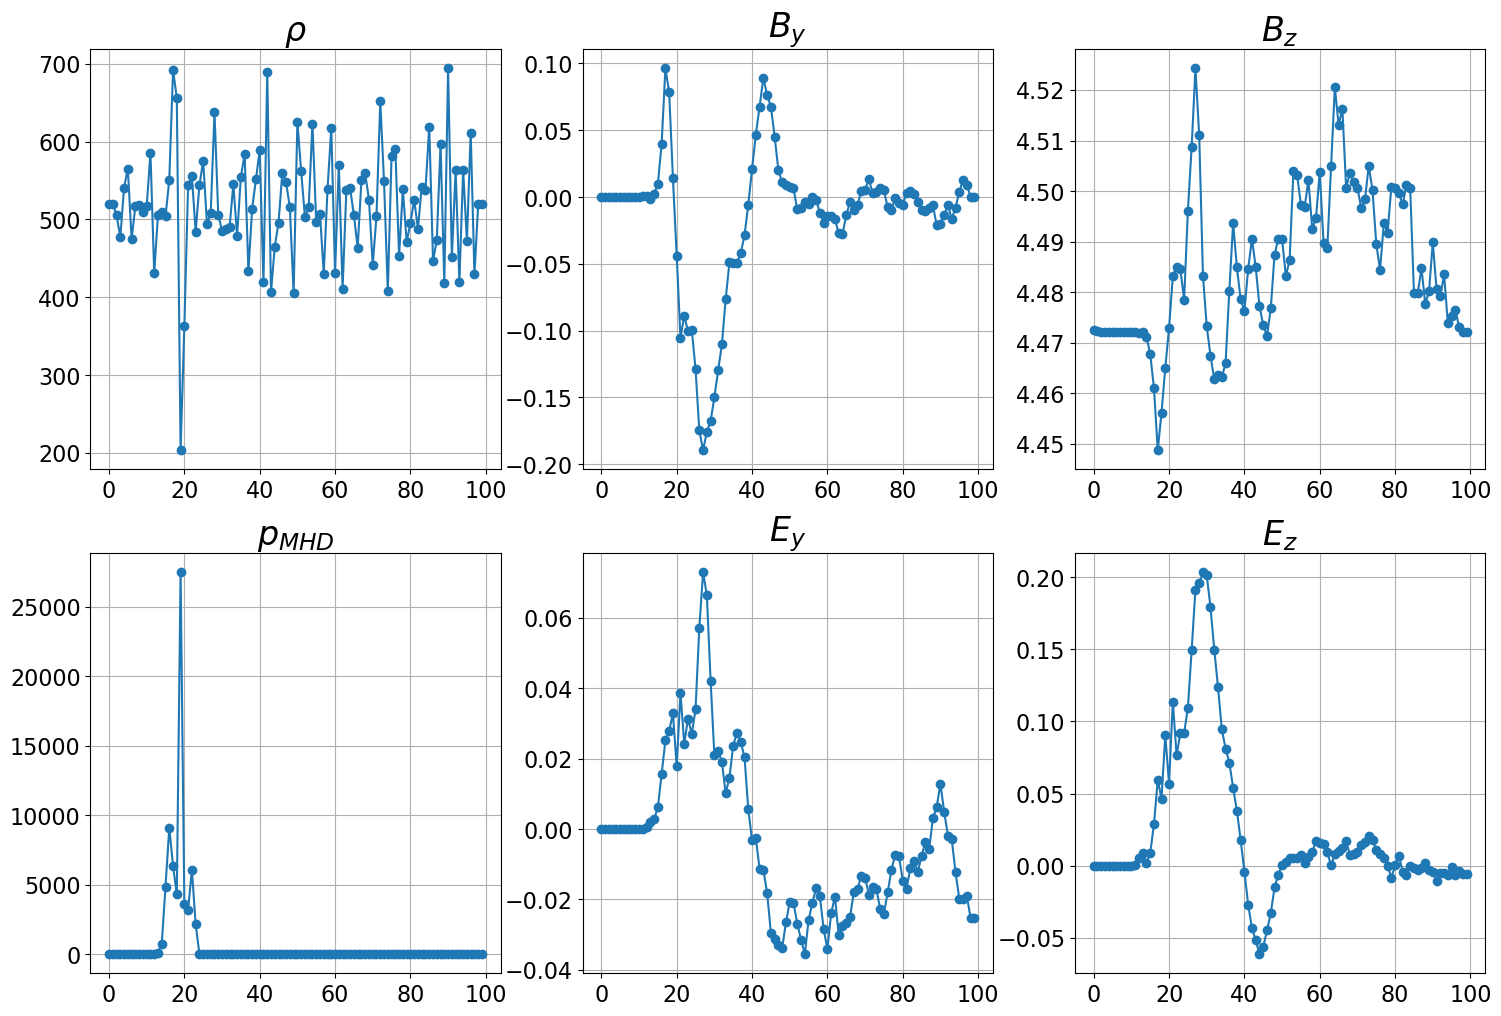

In [ ]:
fig = plt.figure(figsize=(18, 12))
ax1 = fig.add_subplot(231)
ax2 = fig.add_subplot(232)
ax3 = fig.add_subplot(233)
ax4 = fig.add_subplot(234)
ax5 = fig.add_subplot(235)
ax6 = fig.add_subplot(236)

rho_pic = m_electron * zeroth_moment_electron + m_ion * zeroth_moment_ion
bulk_speed_ion_pic = first_moment_ion / (zeroth_moment_ion + 1e-10)
bulk_speed_electron_pic = first_moment_electron / (zeroth_moment_electron + 1e-10)
bulk_speed_pic = (m_electron * bulk_speed_electron_pic + m_ion * bulk_speed_ion_pic) / (m_electron + m_ion)
v_thi_squared_pic = ((second_moment_ion[0, :] + second_moment_ion[4, :] + second_moment_ion[8, :])
                      - zeroth_moment_ion * (bulk_speed_ion_pic[0, :]**2 + bulk_speed_ion_pic[1, :]**2 + bulk_speed_ion_pic[2, :]**2)) \
                      / 3.0 / (zeroth_moment_ion + 1e-10)
v_the_squared_pic = ((second_moment_electron[0, :] + second_moment_electron[4, :] + second_moment_electron[8, :])
                     - zeroth_moment_electron * (bulk_speed_electron_pic[0, :]**2 + bulk_speed_electron_pic[1, :]**2 + bulk_speed_electron_pic[2, :]**2)) \
                      / 3.0 / (zeroth_moment_electron + 1e-10)
p_pic = zeroth_moment_electron * m_electron * v_the_squared_pic / 2.0 + zeroth_moment_ion * m_ion * v_thi_squared_pic / 2.0
p_mhd = p_pic

ax1.plot(x_coordinate_pic, rho_pic, marker='o')
ax2.plot(x_coordinate_pic, B[1, :], marker='o')
ax3.plot(x_coordinate_pic, B[2, :], marker='o')
ax4.plot(x_coordinate_pic, p_mhd, marker='o')
ax5.plot(x_coordinate_pic, E[1, :], marker='o')
ax6.plot(x_coordinate_pic, E[2, :], marker='o')

ax1.set_title(r"$\rho$", fontsize=24)
ax2.set_title(r"$B_y$", fontsize=24)
ax3.set_title(r"$B_z$", fontsize=24)
ax4.set_title(r"$p_{MHD}$", fontsize=24)
ax5.set_title(r"$E_y$", fontsize=24)
ax6.set_title(r"$E_z$", fontsize=24)
ax1.tick_params(labelsize=16)
ax2.tick_params(labelsize=16)
ax3.tick_params(labelsize=16)
ax4.tick_params(labelsize=16)
ax5.tick_params(labelsize=16)
ax6.tick_params(labelsize=16)
ax1.grid()
ax2.grid()
ax3.grid()
ax4.grid()
ax5.grid()
ax6.grid()

plt.show()

動画作成

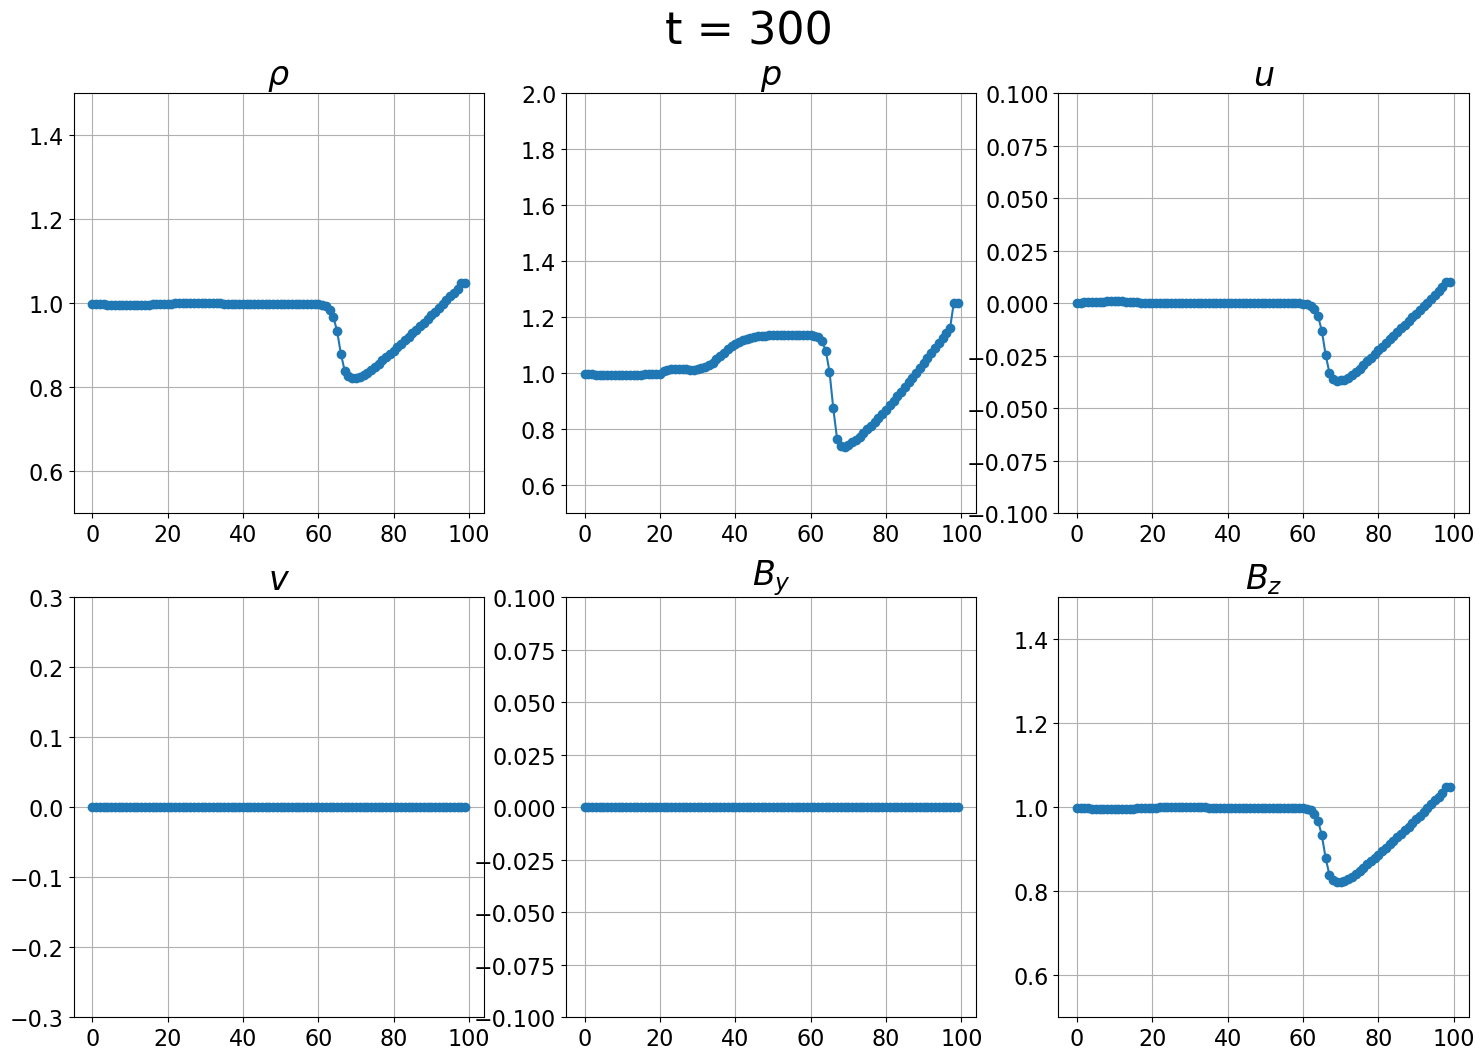

In [ ]:
fig = plt.figure(figsize=(18, 12))
ax1 = fig.add_subplot(231)
ax2 = fig.add_subplot(232)
ax3 = fig.add_subplot(233)
ax4 = fig.add_subplot(234)
ax5 = fig.add_subplot(235)
ax6 = fig.add_subplot(236)

filename = "Alfven_MHD-PIC_MHD.mp4"

interval = 5
for i in range(0, steps+1, interval):
    ax1.clear()
    ax2.clear()
    ax3.clear()
    ax4.clear()
    ax5.clear()
    ax6.clear()

    U = np.load(f"results_MH_alfven/U1_{i}.npy")
    rho = U[0, :]
    u = U[1, :] / rho 
    v = U[2, :] / rho 
    w = U[3, :] / rho 
    Bx = U[4, :]
    By = U[5, :]
    Bz = U[6, :]
    e = U[7, :]
    p = (gamma_mhd-1) * (e - rho*(u**2+v**2+w**2)/2 - (Bx**2+By**2+Bz**2)/2)

    ax1.plot(x_coordinate_mhd, rho / rho0_mhd, marker='o')
    ax2.plot(x_coordinate_mhd, p / p0_mhd, marker='o')
    ax3.plot(x_coordinate_mhd, u, marker='o')
    ax4.plot(x_coordinate_mhd, v, marker='o')
    ax5.plot(x_coordinate_mhd, By / B0_mhd, marker='o')
    ax6.plot(x_coordinate_mhd, Bz / B0_mhd, marker='o')

    ax1.set_ylim(0.5, 1.5)
    ax2.set_ylim(0.5, 2.0)
    ax3.set_ylim(-0.1, 0.1)
    ax4.set_ylim(-0.3, 0.3)
    ax5.set_ylim(-0.1, 0.1)
    ax6.set_ylim(0.5, 1.5)

    ax1.set_title(r"$\rho$", fontsize=24)
    ax2.set_title(r"$p$", fontsize=24)
    ax3.set_title(r"$u$", fontsize=24)
    ax4.set_title(r"$v$", fontsize=24)
    ax5.set_title(r"$B_y$", fontsize=24)
    ax6.set_title(r"$B_z$", fontsize=24)
    ax1.tick_params(labelsize=16)
    ax2.tick_params(labelsize=16)
    ax3.tick_params(labelsize=16)
    ax4.tick_params(labelsize=16)
    ax5.tick_params(labelsize=16)
    ax6.tick_params(labelsize=16)
    ax1.grid()
    ax2.grid()
    ax3.grid()
    ax4.grid()
    ax5.grid()
    ax6.grid()

    plt.suptitle(f"t = {i}", y=0.95, fontsize=32)

    fig.savefig(f'./pictures/{i}.png', dpi=200)


img = cv2.imread(f'./pictures/0.png')
framesize = (img.shape[1], img.shape[0])
fps = 5.0

fourcc = cv2.VideoWriter_fourcc('m','p','4','v')
video  = cv2.VideoWriter(filename=filename, fourcc=fourcc, fps=fps, frameSize=framesize)

for i in range(0, steps, interval):
    img = cv2.imread(f'./pictures/{i}.png')
    video.write(img)
video.release()

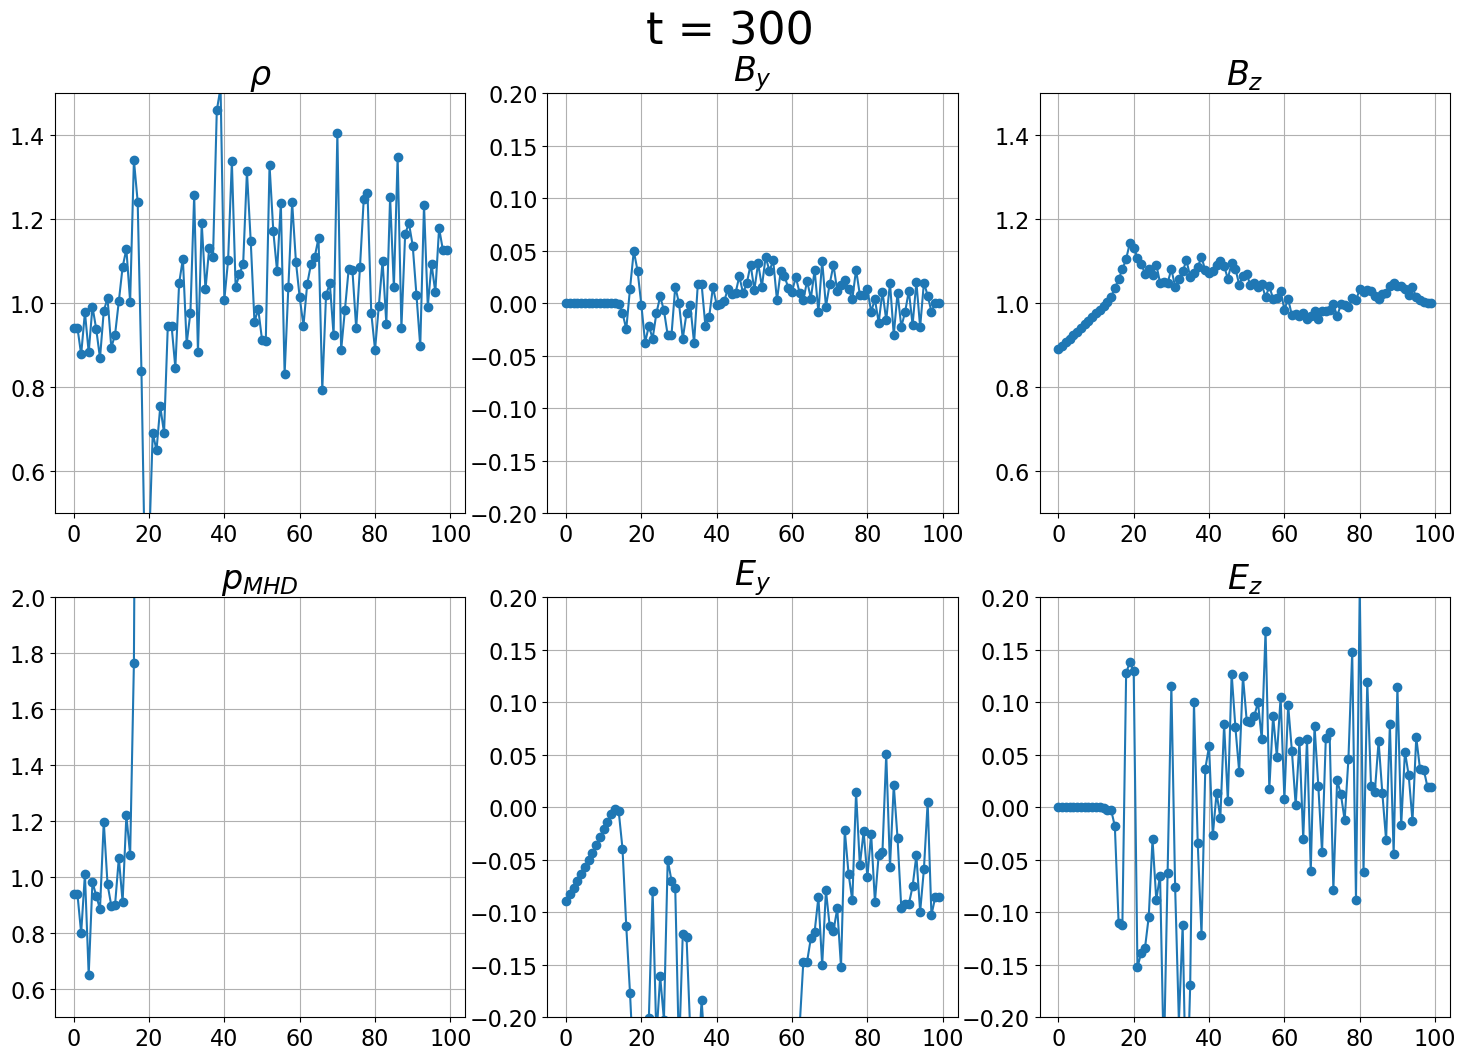

In [ ]:
fig = plt.figure(figsize=(18, 12))
ax1 = fig.add_subplot(231)
ax2 = fig.add_subplot(232)
ax3 = fig.add_subplot(233)
ax4 = fig.add_subplot(234)
ax5 = fig.add_subplot(235)
ax6 = fig.add_subplot(236)

filename = "Alfven_MHD-PIC_PIC.mp4"

interval = 5
for i in range(0, steps+1, interval):
    ax1.clear()
    ax2.clear()
    ax3.clear()
    ax4.clear()
    ax5.clear()
    ax6.clear()

    B = np.load(f"results_MH_alfven/B_{i}.npy")
    E = np.load(f"results_MH_alfven/E_{i}.npy")
    x_pic_ion = np.load(f"results_MH_alfven/x_ion_{i}.npy")
    x_pic_electron = np.load(f"results_MH_alfven/x_electron_{i}.npy")
    v_pic_ion = np.load(f"results_MH_alfven/v_ion_{i}.npy")
    v_pic_electron = np.load(f"results_MH_alfven/v_electron_{i}.npy")

    zeroth_moment_ion = np.zeros(nx_pic)
    zeroth_moment_electron = np.zeros(nx_pic)
    zeroth_moment_ion = get_zeroth_moment(x_pic_ion, nx_pic, dx_pic, zeroth_moment_ion)
    zeroth_moment_electron = get_zeroth_moment(x_pic_electron, nx_pic, dx_pic, zeroth_moment_electron)
    first_moment_ion = np.zeros([3, nx_pic])
    first_moment_electron = np.zeros([3, nx_pic])
    first_moment_ion = get_first_moment(c, v_pic_ion, x_pic_ion, nx_pic, dx_pic, first_moment_ion)
    first_moment_electron = get_first_moment(c, v_pic_electron, x_pic_electron, nx_pic, dx_pic, first_moment_electron)
    second_moment_ion = np.zeros([9, nx_pic])
    second_moment_electron = np.zeros([9, nx_pic])
    second_moment_ion = get_second_moment(c, v_pic_ion, x_pic_ion, nx_pic, dx_pic, second_moment_ion)
    second_moment_electron = get_second_moment(c, v_pic_electron, x_pic_electron, nx_pic, dx_pic, second_moment_electron)

    rho_pic = m_electron * zeroth_moment_electron + m_ion * zeroth_moment_ion
    bulk_speed_ion_pic = first_moment_ion / (zeroth_moment_ion + 1e-10)
    bulk_speed_electron_pic = first_moment_electron / (zeroth_moment_electron + 1e-10)
    bulk_speed_pic = (m_electron * bulk_speed_electron_pic + m_ion * bulk_speed_ion_pic) / (m_electron + m_ion)
    v_thi_squared_pic = ((second_moment_ion[0, :] + second_moment_ion[4, :] + second_moment_ion[8, :])
                      - zeroth_moment_ion * (bulk_speed_ion_pic[0, :]**2 + bulk_speed_ion_pic[1, :]**2 + bulk_speed_ion_pic[2, :]**2)) \
                      / 3.0 / (zeroth_moment_ion + 1e-10)
    v_the_squared_pic = ((second_moment_electron[0, :] + second_moment_electron[4, :] + second_moment_electron[8, :])
                      - zeroth_moment_electron * (bulk_speed_electron_pic[0, :]**2 + bulk_speed_electron_pic[1, :]**2 + bulk_speed_electron_pic[2, :]**2)) \
                      / 3.0 / (zeroth_moment_electron + 1e-10)

    p_pic = zeroth_moment_electron * m_electron * v_the_squared_pic / 2.0 + zeroth_moment_ion * m_ion * v_thi_squared_pic / 2.0
    p_mhd = p_pic

    ax1.plot(x_coordinate_pic, rho_pic / rho0_mhd, marker='o')
    ax2.plot(x_coordinate_pic, B[1, :] / B0_pic, marker='o')
    ax3.plot(x_coordinate_pic, B[2, :] / B0_pic, marker='o')
    ax4.plot(x_coordinate_pic, p_mhd / p0_mhd, marker='o')
    ax5.plot(x_coordinate_pic, E[1, :], marker='o')
    ax6.plot(x_coordinate_pic, E[2, :], marker='o')

    ax1.set_ylim(0.5, 1.5)
    ax2.set_ylim(-0.2, 0.2)
    ax3.set_ylim(0.5, 1.5)
    ax4.set_ylim(0.5, 2.0)
    ax5.set_ylim(-0.2, 0.2)
    ax6.set_ylim(-0.2, 0.2)

    ax1.set_title(r"$\rho$", fontsize=24)
    ax2.set_title(r"$B_y$", fontsize=24)
    ax3.set_title(r"$B_z$", fontsize=24)
    ax4.set_title(r"$p_{MHD}$", fontsize=24)
    ax5.set_title(r"$E_y$", fontsize=24)
    ax6.set_title(r"$E_z$", fontsize=24)
    ax1.tick_params(labelsize=16)
    ax2.tick_params(labelsize=16)
    ax3.tick_params(labelsize=16)
    ax4.tick_params(labelsize=16)
    ax5.tick_params(labelsize=16)
    ax6.tick_params(labelsize=16)
    ax1.grid()
    ax2.grid()
    ax3.grid()
    ax4.grid()
    ax5.grid()
    ax6.grid()

    plt.suptitle(f"t = {i}", y=0.95, fontsize=32)

    fig.savefig(f'./pictures/{i}.png', dpi=200)


img = cv2.imread(f'./pictures/0.png')
framesize = (img.shape[1], img.shape[0])
fps = 5.0

fourcc = cv2.VideoWriter_fourcc('m','p','4','v')
video  = cv2.VideoWriter(filename=filename, fourcc=fourcc, fps=fps, frameSize=framesize)

for i in range(0, steps, interval):
    img = cv2.imread(f'./pictures/{i}.png')
    video.write(img)
video.release()